# Project Notebook

## General Imports

In [1]:
import os
import json
import traceback

## Import the fablib Library

In [2]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Token File,/home/fabric/.tokens.json
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
Bastion Username,jackson_nichols_0000155246
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Bastion Host,bastion.fabric-testbed.net
Bastion Private Key Passphrase,None
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Private Key Passphrase,None


## MFLib Imports

In [3]:
import mflib 
print(f"MFLib version  {mflib.__version__} " )

from mflib.mflib import MFLib

MFLib version  1.0.4 


In [4]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager

try:
    fablib = fablib_manager()
                    
    fablib.show_config()
except Exception as e:
    print(f"Exception: {e}")

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Token File,/home/fabric/.tokens.json
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
Bastion Username,jackson_nichols_0000155246
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Bastion Host,bastion.fabric-testbed.net
Bastion Private Key Passphrase,None
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Private Key Passphrase,None


## Establish the sets of nodes

"node_conf" will hold the collection of L3 Nodes
"net_conf" will hold the L2 nodes connecting the L3 Nodes
"route_conf" is the live connections between nodes

In [3]:
#Needs polish
slice_name="topology-test-" + fablib.get_bastion_username()

[site1,site2,site3,site4,site5] = fablib.get_random_sites(count=5, avoid=["CERN","DALL","GPN","LBNL","RENC","SALT","TACC","UKY","WASH","NCSA","LOSA","GATECH","INDI","MAX", "MASS","NEWY","SRI","UCSD"])

node_conf = [
 {'name': "consumer1", 'site': site1, 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools', 'iperf3', 'moreutils']}, 
 {'name': "consumer2", 'site': site2, 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools', 'iperf3', 'moreutils']}, 
 {'name': "server",  'site': site3, 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools', 'iperf3', 'moreutils']}, 
 {'name': "router1", 'site': site4, 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools']}, 
 {'name': "router2", 'site': site5, 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools']}
]

net_conf = [
 {"name": "net_c1r1", "subnet": "10.10.1.0/24", "nodes": [{"name": "consumer1", "addr": "10.10.1.100"}, {"name": "router1", "addr": "10.10.1.10"}]},
 {"name": "net_c1r2", "subnet": "10.10.2.0/24", "nodes": [{"name": "consumer1", "addr": "10.10.2.200"}, {"name": "router2", "addr": "10.10.2.20"}]},
 {"name": "net_c2r2", "subnet": "10.10.3.0/24", "nodes": [{"name": "consumer2", "addr": "10.10.3.200"}, {"name": "router2", "addr": "10.10.3.20"}]},
 {"name": "net_sr1",  "subnet": "10.10.4.0/24", "nodes": [{"name": "server", "addr": "10.10.4.100"}, {"name": "router1", "addr": "10.10.4.10"}]},
 {"name": "net_sr2",  "subnet": "10.10.5.0/24", "nodes": [{"name": "server", "addr": "10.10.5.200"}, {"name": "router2", "addr": "10.10.5.20"}]}
]

route_config = [
    #consumer 1 links
    {"addr": "10.10.4.0/24", "gw": "10.10.1.10", "nodes": ["consumer1"]}, #can reach 10.10.4.0 (server) subnet through router1 gw
    {"addr": "10.10.3.0/24", "gw": "10.10.2.20", "nodes": ["consumer1"]}, #can reach 10.10.3.0 (consumer2) subnet through router2 gw
    {"addr": "10.10.5.0/24", "gw": "10.10.2.20", "nodes": ["consumer1"]}, #can reach 10.10.5.0 (server) subnet through router2 gw
    #consumer 2
    {"addr": "10.10.2.0/24", "gw": "10.10.3.20", "nodes": ["consumer2"]}, #can reach 10.10.2.0 (consumer1) subnet through router2 gw
    {"addr": "10.10.5.0/24", "gw": "10.10.3.20", "nodes": ["consumer2"]}, #can reach 10.10.5.0 (server) subnet through router2 gw
    #server links
    {"addr": "10.10.1.0/24", "gw": "10.10.4.10", "nodes": ["server"]}, #can reach 10.10.1.0 (consumer1) subnet through router1 gw
    {"addr": "10.10.2.0/24", "gw": "10.10.5.20", "nodes": ["server"]}, #can reach 10.10.2.0 (consumer1) subnet through router2 gw
    {"addr": "10.10.3.0/24", "gw": "10.10.5.20", "nodes": ["server"]}  #can reach 10.10.3.0 (consumer2) subnet through router2 gw
]

"""
node_conf = [
 {'name': "consumer1", 'site': site1, 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools', 'iperf3', 'moreutils']},
 {'name': "server", 'site': site3, 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools', 'iperf3', 'moreutils']}, 
 {'name': "router1", 'site': site4, 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools']}
]

net_conf = [
 {"name": "net_c1r1", "subnet": "10.10.1.0/24", "nodes": [{"name": "consumer1", "addr": "10.10.1.2"}, {"name": "router1", "addr": "10.10.1.1"}]},
 {"name": "net_sr1",  "subnet": "10.10.3.0/24", "nodes": [{"name": "server", "addr": "10.10.3.2"}, {"name": "router1", "addr": "10.10.3.1"}]}
]

route_config = [
 {"addr": "10.10.3.0/24", "gw": "10.10.1.1", "nodes": ["consumer1"]},
 {"addr": "10.10.1.0/24", "gw": "10.10.3.1", "nodes": ["server"]}
]
"""

print(f"Setting up slice {slice_name}")
print(f"Using sites {site1}, {site2}, {site3}, {site4}, {site5}")

Setting up slice topology-test-jackson_nichols_0000155246
Using sites AMST, EDC, UTAH, HAWI, MICH


## Check resources

Check if you have a pre-existing slice by this name already running

Don't attempt to submit the slice if you've already defined one by this name

In [4]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)

You don't have a slice named topology-test-jackson_nichols_0000155246 yet.
Continue to the next step to make one.


## Node Set-up

Following example code, this will set-up the L2 & L3 networks per the configured lists

In [5]:
# this cell sets up the nodes
for n in node_conf:
    slice.add_node(name=n['name'], site=n['site'], 
                   cores=n['cores'], 
                   ram=n['ram'], 
                   disk=n['disk'], 
                   image=n['image'])

In [6]:
# this cell iterates each entry in the net_conf table
for n in net_conf:
    ifaces = []
    for node in n['nodes']:
        ifaces.append( slice.get_node(node["name"]).add_component(model="NIC_Basic", name=n["name"]).get_interfaces()[0] )
    slice.add_l2network(name=n["name"], interfaces=ifaces)

## Set-up the MFLib monitoring node
Create a node that will monitor the status of the other nodes

This step GREATLY increases slice requisition time. If debugging node links, do not add the MFLib monitoring tool.

In [9]:
# Add measurement node to topology using static method.
MFLib.addMeasNode(slice, disk=100, image='docker_ubuntu_20')
print("MFLib Node added")

MFLib Node added


## Submit the slice for use

In [7]:
slice.submit()


Retry: 13, Time: 573 sec


ID,5bf56d7e-b6f9-4f82-a678-62ef52f14f38
Name,topology-test-jackson_nichols_0000155246
Lease Expiration (UTC),2024-03-14 21:10:13 +0000
Lease Start (UTC),2024-03-13 21:10:13 +0000
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
7440a32a-da2b-43dd-bb72-89713a9276dc,consumer1,2,4,10,default_ubuntu_20,qcow2,amst-w2.fabric-testbed.net,AMST,ubuntu,2001:610:2d0:fabc:f816:3eff:fe1e:642b,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:610:2d0:fabc:f816:3eff:fe1e:642b,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
ad9233d8-bdc2-4a78-8bdb-c320927a31e2,consumer2,2,4,10,default_ubuntu_20,qcow2,edc-w1.fabric-testbed.net,EDC,ubuntu,2620:0:c80:1003:f816:3eff:fe06:8da6,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1003:f816:3eff:fe06:8da6,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
6f7f6638-47bf-4b7a-ab5a-f74b4adfc925,router1,2,4,10,default_ubuntu_20,qcow2,hawi-w3.fabric-testbed.net,HAWI,ubuntu,2607:f278:1:202:f816:3eff:fe92:19cf,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2607:f278:1:202:f816:3eff:fe92:19cf,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
6e96d1c9-b485-4fa0-9f81-6e5229d00390,router2,2,4,10,default_ubuntu_20,qcow2,mich-w1.fabric-testbed.net,MICH,ubuntu,2607:f018:110:11:f816:3eff:feb2:4582,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2607:f018:110:11:f816:3eff:feb2:4582,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
10ef6934-3a04-4728-b1c5-41047fa9b9fe,server,2,4,10,default_ubuntu_20,qcow2,utah-w4.fabric-testbed.net,UTAH,ubuntu,2001:1948:417:7:f816:3eff:fe70:faec,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:1948:417:7:f816:3eff:fe70:faec,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
771e1661-4c8f-4f78-a9fe-080936ae5c15,net_c1r1,L2,L2STS,None,None,None,Active,
a714a05f-4718-49be-a5ef-7b13d5cf22e8,net_c1r2,L2,L2STS,None,None,None,Active,
07ef6412-4d7c-4deb-8e4b-925061688903,net_c2r2,L2,L2STS,None,None,None,Active,
b6033545-7d22-41dc-bbb6-42e7eae8b566,net_sr1,L2,L2STS,None,None,None,Active,
d1ce5b67-687a-404f-95a3-69bbad27a480,net_sr2,L2,L2STS,None,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node
consumer1-net_c1r1-p1,p1,consumer1,net_c1r1,100,config,,2A:01:C7:67:AE:C4,enp7s0,enp7s0,None,4
consumer1-net_c1r2-p1,p1,consumer1,net_c1r2,100,config,,2A:66:EE:B5:B0:F0,enp8s0,enp8s0,None,4
consumer2-net_c2r2-p1,p1,consumer2,net_c2r2,100,config,,06:00:B9:4D:C0:84,enp6s0,enp6s0,None,6
server-net_sr1-p1,p1,server,net_sr1,100,config,,0A:0F:5E:9F:89:53,enp8s0,enp8s0,None,4
server-net_sr2-p1,p1,server,net_sr2,100,config,,02:C4:50:CC:1E:75,enp7s0,enp7s0,None,4
router1-net_sr1-p1,p1,router1,net_sr1,100,config,,02:FD:98:F1:28:2E,enp7s0,enp7s0,None,4
router1-net_c1r1-p1,p1,router1,net_c1r1,100,config,,06:17:FA:26:D0:F2,enp8s0,enp8s0,None,4
router2-net_c1r2-p1,p1,router2,net_c1r2,100,config,,0A:11:E6:AF:F2:5A,enp9s0,enp9s0,None,6
router2-net_c2r2-p1,p1,router2,net_c2r2,100,config,,02:D5:4F:CB:3B:68,enp7s0,enp7s0,None,6
router2-net_sr2-p1,p1,router2,net_sr2,100,config,,06:FC:84:82:86:1E,enp8s0,enp8s0,None,6



Time to print interfaces 591 seconds


'5bf56d7e-b6f9-4f82-a678-62ef52f14f38'

This step will pend until the above slice is ready for use. Helps prevent trying to configure nodes that don't exist.

In [8]:
slice.get_state()
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

## Configure Resources

In [9]:
slice = fablib.get_slice(name=slice_name)

In [10]:
# install packages
# this will take a while and will run in background while you do other steps
for n in node_conf:
    if len(n['packages']):
        node = slice.get_node(n['name'])
        pkg = " ".join(n['packages'])
        node.execute_thread("sudo apt update; sudo apt -y install %s" % pkg)

In [11]:
# bring interfaces up and either assign an address (if there is one) or flush address
from ipaddress import ip_address, IPv4Address, IPv4Network

for net in net_conf:
    for n in net['nodes']:
        if_name = n['name'] + '-' + net['name'] + '-p1'
        iface = slice.get_interface(if_name)
        iface.ip_link_up()
        if n['addr']:
            iface.ip_addr_add(addr=n['addr'], subnet=IPv4Network(net['subnet']))
        else:
            iface.get_node().execute("sudo ip addr flush dev %s"  % iface.get_device_name())

In [12]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for n in slice.get_nodes():
    print("")
    for h in hosts_txt:
        n.execute("echo %s | sudo tee -a /etc/hosts" % h)


10.10.1.100 consumer1
10.10.1.10 router1
10.10.2.200 consumer1
10.10.2.20 router2
10.10.3.200 consumer2
10.10.3.20 router2
10.10.4.100 server
10.10.4.10 router1
10.10.5.200 server
10.10.5.20 router2

10.10.1.100 consumer1
10.10.1.10 router1
10.10.2.200 consumer1
10.10.2.20 router2
10.10.3.200 consumer2
10.10.3.20 router2
10.10.4.100 server
10.10.4.10 router1
10.10.5.200 server
10.10.5.20 router2

10.10.1.100 consumer1
10.10.1.10 router1
10.10.2.200 consumer1
10.10.2.20 router2
10.10.3.200 consumer2
10.10.3.20 router2
10.10.4.100 server
10.10.4.10 router1
10.10.5.200 server
10.10.5.20 router2

10.10.1.100 consumer1
10.10.1.10 router1
10.10.2.200 consumer1
10.10.2.20 router2
10.10.3.200 consumer2
10.10.3.20 router2
10.10.4.100 server
10.10.4.10 router1
10.10.5.200 server
10.10.5.20 router2

10.10.1.100 consumer1
10.10.1.10 router1
10.10.2.200 consumer1
10.10.2.20 router2
10.10.3.200 consumer2
10.10.3.20 router2
10.10.4.100 server
10.10.4.10 router1
10.10.5.200 server
10.10.5.20 router2


In [13]:
# enable IPv4 forwarding on all nodes
for n in slice.get_nodes():
    n.execute("sudo sysctl -w net.ipv4.ip_forward=1")

net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1


In [14]:
# set up static routes
for rt in route_config:
    for n in rt['nodes']:
        slice.get_node(name=n).ip_route_add(subnet=IPv4Network(rt['addr']), gateway=rt['gw'])

## Ping Test
This step will ping each node from the consumers & server nodes. This step serves as a means to ensure all the connections are linked correclty and noone is "blind" to the netowrk.

In [15]:
#Consumer 1
node = slice.get_node(name="consumer1")
try:
    stdout, stderr = node.execute(f'ping -c 1 consumer1')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 consumer2')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 router1')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 router2')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 server')
except Exception as e:
    print(f"Exception: {e}")

PING consumer1 (10.10.1.100) 56(84) bytes of data.
64 bytes from consumer1 (10.10.1.100): icmp_seq=1 ttl=64 time=0.014 ms

--- consumer1 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 0.014/0.014/0.014/0.000 ms
====
PING consumer2 (10.10.3.200) 56(84) bytes of data.
64 bytes from consumer2 (10.10.3.200): icmp_seq=1 ttl=63 time=251 ms

--- consumer2 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 250.991/250.991/250.991/0.000 ms
====
PING router1 (10.10.1.10) 56(84) bytes of data.
64 bytes from router1 (10.10.1.10): icmp_seq=1 ttl=64 time=447 ms

--- router1 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 447.427/447.427/447.427/0.000 ms
====
PING router2 (10.10.2.20) 56(84) bytes of data.
64 bytes from router2 (10.10.2.20): icmp_seq=1 ttl=64 time=117 ms

--- router2 ping statistics ---
1 packets transmitted, 1 received, 0%

In [16]:
#Consumer 2
node = slice.get_node(name="consumer2")
try:
    stdout, stderr = node.execute(f'ping -c 1 consumer1')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 consumer2')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 router1')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 router2')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 server')
except Exception as e:
    print(f"Exception: {e}")

PING consumer1 (10.10.2.200) 56(84) bytes of data.
64 bytes from consumer1 (10.10.2.200): icmp_seq=1 ttl=63 time=125 ms

--- consumer1 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 125.410/125.410/125.410/0.000 ms
====
PING consumer2 (10.10.3.200) 56(84) bytes of data.
64 bytes from consumer2 (10.10.3.200): icmp_seq=1 ttl=64 time=0.042 ms

--- consumer2 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 0.042/0.042/0.042/0.000 ms
====
 ping: connect: Network is unreachable
 ====
PING router2 (10.10.3.20) 56(84) bytes of data.
64 bytes from router2 (10.10.3.20): icmp_seq=1 ttl=64 time=7.88 ms

--- router2 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 7.884/7.884/7.884/0.000 ms
====
PING server (10.10.5.200) 56(84) bytes of data.
64 bytes from server (10.10.5.200): icmp_seq=1 ttl=63 time=81.0 ms

--- server ping statistics -

In [17]:
#Server
node = slice.get_node(name="server")
try:
    stdout, stderr = node.execute(f'ping -c 1 consumer1')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 consumer2')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 router1')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 router2')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 server')
except Exception as e:
    print(f"Exception: {e}")

PING consumer1 (10.10.1.100) 56(84) bytes of data.
64 bytes from consumer1 (10.10.1.100): icmp_seq=1 ttl=63 time=293 ms

--- consumer1 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 292.888/292.888/292.888/0.000 ms
====
PING consumer2 (10.10.3.200) 56(84) bytes of data.
64 bytes from consumer2 (10.10.3.200): icmp_seq=1 ttl=63 time=44.4 ms

--- consumer2 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 44.415/44.415/44.415/0.000 ms
====
PING router1 (10.10.4.10) 56(84) bytes of data.
64 bytes from router1 (10.10.4.10): icmp_seq=1 ttl=64 time=74.2 ms

--- router1 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 74.204/74.204/74.204/0.000 ms
====
PING router2 (10.10.5.20) 56(84) bytes of data.
64 bytes from router2 (10.10.5.20): icmp_seq=1 ttl=64 time=36.5 ms

--- router2 ping statistics ---
1 packets transmitted, 1 received, 0

## Draw the Topology

Draw the configuration based on the list arguments declared towards the start of this Notebook.

Note -- This does not draw from what FABRIC actually created. It draws what we wanted FABRIC to create. If methods aren't called correctly there will be a disconnect between these two.

In [18]:
l2_nets = []
hosts   = []
l3_nets = []
for n in slice.get_l2networks():
    print( "L2 " + n.get_name() )
    l2_nets.append( (n.get_name(), {'color': 'lavender'}) )
for n in slice.get_l3networks():
    print( "L3 " + n.get_name() )
    l3_nets.append( (n.get_name(), {'color': 'pink'}) )
for n in slice.get_nodes():
    print( "Node " + n.get_name() )
    hosts.append( (n.get_name(), {'color': 'lightblue'}) )
nodes   = l2_nets + l3_nets + hosts

edges = []
for iface in slice.get_interfaces():
    ifDict = iface.toDict()
    edges.append( (ifDict['network'], ifDict['node'], {'label': ifDict['physical_dev'] + '\n' + ifDict['ip_addr'] + '\n' + ifDict['mac']}) )
     

L2 net_c1r2
L2 net_c1r1
L2 net_c2r2
L2 net_sr1
L2 net_sr2
Node consumer1
Node consumer2
Node server
Node router1
Node router2


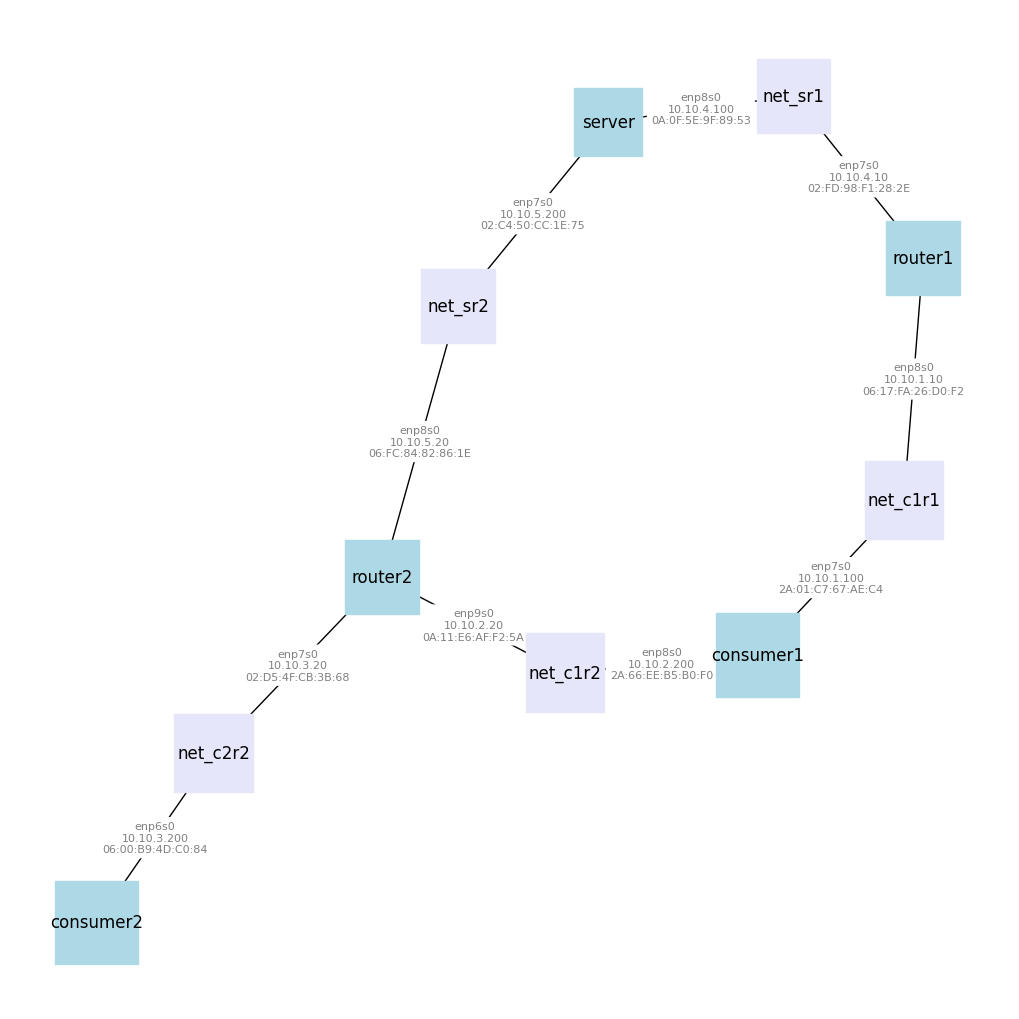

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);

nx.draw_networkx_edge_labels(G, pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

## Log into nodes
Get the ssh commands for the Consumers, Routers, and Server

In [23]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
slice_info = [{'Name': n.get_name(), 'SSH command': n.get_ssh_command()} for n in slice.get_nodes()]
pd.DataFrame(slice_info).set_index('Name')

,SSH command
Name,
consumer1,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3030:f816:3eff:fe6f:5f14
consumer2,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3050:f816:3eff:feb2:7e26
server,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:5e8:ff00:ffff:f816:3eff:fe59:f925
router1,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@131.94.57.39
router2,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:1948:417:7:f816:3eff:fe15:9f61
meas-node,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1003:f816:3eff:fe02:6e27


## Initialize MFLib object

In [24]:
%%time
mf = MFLib(slice_name)

Inititializing slice "topology-test-jackson_nichols_0000155246" for MeasurementFramework.
Found meas node as meas-node at 2620:0:c80:1003:f816:3eff:fe02:6e27
Bootstrap status not found. Will now start bootstrap process...
Generating MFUser Keys...
MFUser key generation Done.
Installing mfuser account...
Installing mfuser account done.
Cloning Measurement Framework Repository from github.com...
Cloning Measurement Framework Repository from github.com done.
Configuring Measurement Network...
Measurement Network setup complete.
Generating Ansible Inventory for Measurement Framework Deployment...
Ansible Inventory for Measurement Framework Deployment generated and saved.
Bootstrapping measurement node via bash...
Starting Bootstrap Process on Measure Node (bash script)...
Bootstrap Process on Measure Node (bash script) done.
Bootstrapping measurement node via ansible...
Starting Bootstrap Process on Measure Node (Ansible Playbook)...
Bootstrap Process on Measure Node (Ansible Playbook) don

## Install Prometheus and Grafana

Install the 2 tools and then get the access information

In [25]:
%%time
instrumetize_results = mf.instrumentize( ["prometheus"] )

Instrumentizing slice "topology-test-jackson_nichols_0000155246"
   Setting up Prometheus...
   Setting up Prometheus done.
   Setting up grafana_manager & dashboards...
   Setting up grafana_manager & dashboards done.
Instrumentize Process Complete.
CPU times: user 1.81 s, sys: 53.4 ms, total: 1.87 s
Wall time: 1min 43s


In [26]:
# Grafana SSH Tunnel Command
# mf.grafana_tunnel_local_port = 10010 # optionally change the port
print(mf.grafana_tunnel)

print(f"Browse to https://localhost:{mf.grafana_tunnel_local_port}/grafana/dashboards?query=%2A")

ssh -L 10010:localhost:443 -F ssh_config -i slice_key ubuntu@2620:0:c80:1003:f816:3eff:fe02:6e27
Browse to https://localhost:10010/grafana/dashboards?query=%2A


In [27]:
# The grafana_manager service was created by the mf.instrumentize call.
# Get access info for Grafana by using the mflib.info call to the grafana_manager.
# Create a dictionary to pass to the service.
data = {}
# Set the info you want to get.
data["get"] = ["admin_password"]
# Call info using service name and data dictionary.
info_results = mf.info("grafana_manager", data)
print(info_results)

{'success': True, 'msg': '', 'grafana_admin_password': 'TrMtAtPG'}


## Cleanup
Step to delete the slice

In [ ]:
slice = fablib.get_slice(name=slice_name)
slice.delete()